In [1]:
%load_ext autoreload
%autoreload 2

# NOTES

- [Compound Clustering Tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html)
- [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [sentence-transforrmers clustering](https://www.sbert.net/examples/applications/clustering/README.html)
  - [fast_clustering](https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py)
    - 50k sentences in less than 5 seconds).
    - In a large list of sentences it searches for local communities: A local community is a set of highly similar sentences.


In [2]:
import pandas as pd
from thesis_work.utils import get_largest_fragment_from_smiles
from thesis_work.chemberta.model_descriptors import (
    gen_embeddings,
    initialize_model_tokenizer,
    get_model_descriptors as get_model_descriptors_chemberta,
)
from thesis_work.utils import get_ecfp_descriptor, get_ecfp_descriptors
from thesis_work.data import load_data, load_mixed_interacted_compounds

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from thesis_work.clustering.butina import apply_butina, custom_butina_only_ecfp
from thesis_work.clustering.utils import efcp_similarity_matrix, efcp_distance_matrix
from thesis_work.clustering.dimensionality_reduction import apply_umap, plot_umap
import logging
from thesis_work.clustering.k_means import apply_k_means
from thesis_work.chemprop.model_descriptors import (
    get_model_descriptors as get_model_descriptors_chemprop,
)
from thesis_work.clustering.evaluation import silhouette_index

import os


# To disable all wandb logging
os.environ["WANDB_MODE"] = "disabled"

# To set the notebook name
os.environ["WANDB_NOTEBOOK_NAME"] = "./clustering.ipynb"

import wandb

wandb.login()


# Silence RDKit warnings
# logger = RDLogger.logger()
# logger.setLevel(RDLogger.CRITICAL)

# Silence transformers warnings
# logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
# from transformers import logging
# logging.set_verbosity_error()


## print numpy array more beautifully
# np.set_printoptions(suppress=True)
# np.set_printoptions(precision=3)

INFO:numba.cuda.cudadrv.driver:init


True

# Config Parameters


In [3]:
project_name = "Cluster-Experiments"
# project_name = "Cluster-Experiments-Temp"

random_state = 42
device = "cuda"
# device  = "cpu"

In [4]:
run = wandb.init(
    project=project_name,
    config={
        "random_state": random_state,
        "device": device,
    },
)

# Data


## Ours


In [5]:
protein_type = "kinase"
# protein_type = "protease"
# protein_type = "gpcr"

wandb.config.update({"protein_type": protein_type})

data = load_data(protein_type=protein_type)
wandb.config.update({"dataset_size": data.shape[0]})

smiles = data["text"].tolist()
data

,text,labels
0,O=C(Cc1cccc2ccccc12)Nc1n[nH]c2ccc(N3CCCS3(=O)=...,1
1,COC(=O)NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc...,1
2,COc1ccccc1Nc1cc(Oc2cc(C)c(C)nc2-c2ccccn2)ccn1,1
3,O=C(/C=C/CN1CCCC1)N1CCOc2cc3ncnc(Nc4ccc(F)c(Cl...,1
4,O=C(Nc1cccc(Nc2cc3c(=O)[nH][nH]c(=O)c3cc2Cl)c1...,1
...,...,...
66304,CS(=O)(=O)c1ccccc1Nc1cccn2nc(Nc3ccc(OCCN4CCCC4...,0
66305,CC(C)n1cc(C(=O)c2cncc(NC(=O)c3ccc4nnnn4c3)c2)c...,0
66306,CNC(=O)c1ccc2[nH]nc(-c3cccc(C(=O)NCc4cccc5cccc...,0
66307,NC(=O)c1c(NC(=O)COC(=O)CCC(=O)c2ccc(Cl)cc2)sc2...,0


## Ours - Mixed Interactive


In [5]:
each_sample_size = 4000
protein_types = ["gpcr", "kinase", "protease"]
protein_types.sort()
protein_labels = list(range(len(protein_types)))

wandb.config.update({"protein_types": protein_types})

data = load_mixed_interacted_compounds(
    protein_types=protein_types,
    each_sample_size=each_sample_size,
    random_state=random_state,
    convert_labels=False,
)
wandb.config.update({"dataset_size": data.shape[0]})

smiles = data["text"].tolist()
data

,text,labels
0,O=C(O)c1ccc(CN(CCc2ccccc2)C(=O)c2ccc(Oc3ccccc3...,0
1,CCc1sc(CCc2cc(OC3CCCCC3)cc(NCc3cc(Cl)cc(NC(=O)...,0
2,COc1cc(OC2CCN(Cc3ccc[n+]([O-])c3C(F)(F)F)CC2)c...,0
3,CCN(c1nc(C)cc(C)n1)c1c(Br)cc(C(C)C)cc1OC,0
4,CCCCCCC(C)(C)c1cc(O)c2c(c1)OC(C)(C)c1cn[nH]c1-2,0
...,...,...
11995,CN(CCO)Cc1csc(C(=O)Nc2ccc(Cl)cc2C(=O)Nc2ccc(Cl...,2
11996,COc1ccc(-n2nc(S(C)(=O)=O)c3c2C(=O)N(c2ccc(C4(C...,2
11997,Cc1cc(C(=O)N2CCC3(CCN(C(=O)Nc4ccc(OC(F)(F)F)cc...,2
11998,CSc1sc(C(=N)N)cc1S(=O)(=O)c1cccc(-c2cccc(C)n2)c1,2


## BBBP


In [5]:
# FIXME: Drop invalid SMILES

# Read in data from MoleculeNet
data = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
data = (
    data[["smiles", "p_np", "name"]]
    .reset_index(drop=True)
    .rename({"smiles": "text", "p_np": "labels"}, axis=1)
)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
data["text"] = data["text"].apply(get_largest_fragment_from_smiles).dropna().astype(str)
wandb.config.update({"dataset_size": data.shape[0]})

# convert to str list
smiles = data["text"].tolist()

data

,text,labels,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin
...,...,...,...
2045,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1,licostinel
2046,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1,ademetionine(adenosyl-methionine)
2047,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1,mesocarb
2048,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1,tofisoline


## BCE - TODO


# Embeddings


## Chemberta


In [6]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
# model_name = "DeepChem/ChemBERTa-77M-MLM"

wandb.config.update({"model_name": model_name})

vector_embeddings = get_model_descriptors_chemberta(
    smiles_series=data["text"],
    model_name=model_name,
    method="simpletransformers",
)

# data["vector"] = pd.DataFrame(get_model_descriptors(
#     smiles_series=data["text"],
#     model_name=model_name,
#     method="simpletransformers",
# )).tolist()

# data[[f"vector_{i}" for i in range(1, embedding_size+1)]] = pd.DataFrame(data["vector"])

print(vector_embeddings.shape)
print(type(vector_embeddings))
print(type(vector_embeddings[0]))

(12000, 384)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
### bert_loves_chemistry version

# model, tokenizer = initialize_model_tokenizer(model_name=model_name)
# vector_embeddings = gen_embeddings(model=model, tokenizer=tokenizer, smiles=smiles)
# vector_embeddings.shape

## Chemprop


In [6]:
model_name = "chemprop"
wandb.config.update({"model_name": model_name})

vector_embeddings = get_model_descriptors_chemprop(smiles_series=data["text"])

print(vector_embeddings.shape)
print(type(vector_embeddings))
print(type(vector_embeddings[0]))

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


100%|██████████| 6000/6000 [00:02<00:00, 2963.68it/s]
                                               

(6000, 25)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [13]:
vector_embeddings

array([[4.24813938, 2.85334063, 0.10889256, ..., 0.73219436, 2.74030447,
        1.98216641],
       [1.72755039, 2.00890899, 0.42296004, ..., 1.16645038, 1.83866763,
        1.19816399],
       [2.19685912, 1.43872404, 0.49104452, ..., 1.74684358, 1.81875014,
        1.55596733],
       ...,
       [2.83035231, 2.22458196, 0.18077081, ..., 0.88491035, 2.38220119,
        1.9877975 ],
       [2.45038486, 2.53556895, 0.21206586, ..., 1.19322145, 1.89814818,
        1.20201302],
       [1.68171072, 3.04080796, 0.04592767, ..., 1.08728933, 1.92475533,
        0.94544512]])

## ECFP

- ECFP4 - 1024
- ECFP6 - 2048


In [28]:
model_name = "ecfp"
radius = 2
nBits = 2048

# wandb.config.update({"model_name": model_name, "radius": radius, "nBits": nBits})


vector_embeddings = get_ecfp_descriptors(
    smiles_series=data["text"], radius=radius, nBits=nBits, inner_return_type="original"
)

# ecfp_vectors = [
#     get_ecfp_descriptor(
#         smiles_str=smiles_str, radius=radius, nBits=nBits, return_type="numpy"
#     )
#     for smiles_str in smiles
# vector_embeddings = np.array(ecfp_vectors)

print(len(vector_embeddings))
print(type(vector_embeddings))
print(type(vector_embeddings[0]))

6000
<class 'list'>
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>


# Dimensionality Reduction


## UMAP

In [7]:
n_components = 20
n_neighbors = 15
min_dist = 0.1
metric = "euclidean"


wandb.config.update(
    {
        "dim_reduction": "UMAP",
        "n_components": n_components,
        "n_neighbors": n_neighbors,
        "min_dist": min_dist,
        "metric": metric,
    }
)


vector_embeddings = apply_umap(
    data=vector_embeddings,
    n_components=n_components,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=random_state,
    device=device,
)

## PCA - TODO

# Cluster

## K-Means


### NOTE

- No need for k-means, but needs for butina.
- Actually, when finding similary compounds in k-means, we might use Tanimoto similarity,
  but noone seem to do so. WHY ??
- [practicalcheminformatics Guide](https://practicalcheminformatics.blogspot.com/2019/01/k-means-clustering.html)

### ECFP4 - 2048

- CPU: 2.0s
- GPU: 1.8s
- Silhouette score: 0.014231271668859027

#### With UMAP

- 20 features
  - Silhouette score: 0.743

### Chemberta Model Embeddings

- Silhouette score: 0.4123
- CPU: 1.3s for (6000, 384)
- GPU: 1.5s for (6000, 384)

#### With UMAP

- 20 features
  - Silhouette score: 0.525

### Chemprop Model Embeddings

- Silhouette score: 0.24
- CPU: ?
- GPU: ?

In [ ]:
# similarity_matrix = efcp_similarity_matrix(smiles_list=smiles, method="fast")

## For checking the slow method
# similarity_matrix_slow = efcp_similarity_matrix(smiles_list=smiles, method="slow")
# np.array_equal(similarity_matrix, similarity_matrix_slow)
# np.allclose(similarity_matrix, similarity_matrix_slow, rtol=0, atol=0.2)

In [7]:
wandb.config.update({"clustering_method": "K-MEANS"})

cluster_range = 20
scores = []
inertias = []


for i in range(2, cluster_range):
    # i = 3

    cluster_labels, inertia = apply_k_means(
        data=vector_embeddings,
        init_method="k-means++",
        n_clusters=i,
        random_state=random_state,
        n_init=1,
        device=device,
    )

    inertias.append(inertia)

    score = silhouette_index(
        target=vector_embeddings, labels=cluster_labels, device=device
    )
    scores.append(score)

    wandb.log({"silhouette_score": score, "inertia": inertia})

    # print(f"Cluster: {i}, Silhouette score: {score:.3f}")

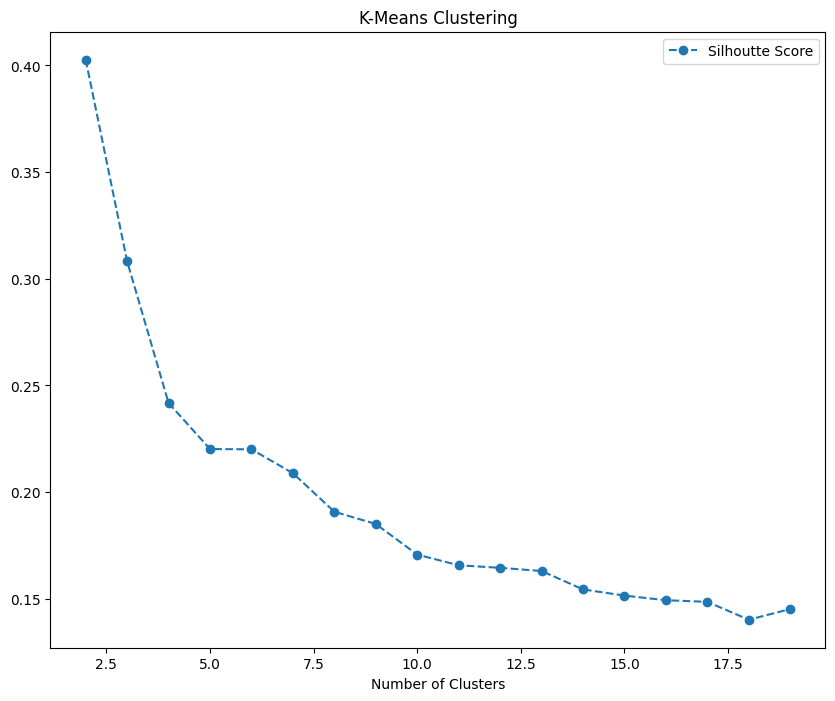

In [8]:
# for cluster_id in range(num_clusters):
#     print(f"Cluster {cluster_id + 1}:")
#     cluster_text_indices = np.where(cluster_labels == cluster_id)[0]
#     for index in cluster_text_indices:
#         print(smiles[index])
#     print("\n")

plt.figure(figsize=(10, 8))
# plt.plot(range(2, len(inertias)+2), inertias, marker='o', linestyle='--', label='Inertia')
plt.plot(
    range(2, len(inertias) + 2),
    scores,
    marker="o",
    linestyle="--",
    label="Silhoutte Score",
)
plt.legend()
plt.xlabel("Number of Clusters")
# plt.ylabel('Inertia Scores')
plt.title("K-Means Clustering")
plt.show()

## Butina

### NOTES

- Silhouette Score:

  - 0.2 Threshold: 0.0007162032683292052 ??

- The higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters. The lower the threshold, the more small clusters and “singletons” appear.

In [3]:
from thesis_work.clustering.utils import generic_distance_matrix
import numpy as np

X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15]])

distance_upper = generic_distance_matrix(
    x=X, metric="euclidean", return_upper_tringular=True
)
distance_upper.shape

(10,)

In [6]:
# threshold = 0.2
# threshold = 0.4
# threshold = 0.6
threshold = 0.8

In [14]:
# clusters = apply_butina(smiles=data["text"], model_name=model_name, distance_metric="euclidian",threshold=0.8)
cluster_labels = apply_butina(
    smiles=data["text"],
    model_name=model_name,
    distance_metric="tanimoto",
    threshold=0.8,
)


# TODO: Needs vector embeddings
silhouette_score = silhouette_index(ecfps, cluster_labels, metric="jaccard")
print("Silhouette Score: ", silhouette_score)

## QPI


In [ ]:
# FIXME: Not working
def quality_partition_index(clusters, distances):
    intra_cluster_distances = [
        min([distances[i][j] for j in cluster]) for i, cluster in enumerate(clusters)
    ]
    min_intra_cluster_distance = min(intra_cluster_distances)
    max_inter_cluster_distance = max(
        [distances[i][j] for i in range(len(distances)) for j in range(i)]
    )

    return min_intra_cluster_distance / max_inter_cluster_distance


qpi = quality_partition_index(clusters, distances)
print("Quality Partition Index: ", qpi)

# END WANDB


In [10]:
if wandb.run is not None:
    wandb.finish()

inertia,█▇▆▇▅▅▄▃▂▂▂▂▁▁▁▁▁▁
silhouette_score,██▁▅▁▁▁▂▁▁▁▁▁▂▁▂▂▂
inertia,10633.25977
silhouette_score,0.27417
